# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 1. Метрики и меры схожести между временными рядами.**

Смените рабочую директорию с помощью команды `chdir()`. Для этого передайте этой команде свой путь до каталога, в котором содержатся материалы первой практической работы. После выполнения этой команды все последующие операции с файлами и каталогами будут производиться относительно указанного каталога.

In [21]:
import os

practice_dir_path = r'C:\Users\Андрей гл\OBUCHENIE\3 СЕМЕСТР\репозиторий1\TimeSeriesCourse\practice\01 Basics'
os.chdir(practice_dir_path)

Выполните команды, которые автоматически перезагружают все импортированные модули при их изменении.

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Импортируйте библиотеки и модули, необходимые для реализации практической работы 1.

In [23]:
import numpy as np
import random
from sktime.distances import euclidean_distance, dtw_distance, pairwise_distance
from sklearn.metrics import silhouette_score
import cv2
import imutils
import glob
import matplotlib.pyplot as plt


In [24]:
from modules.metrics import ED_distance, norm_ED_distance, DTW_distance

In [25]:
from modules.pairwise_distance import PairwiseDistance

In [26]:
from modules.clustering import TimeSeriesHierarchicalClustering

In [27]:
from modules.classification import TimeSeriesKNN, calculate_accuracy

In [28]:
from modules.image_converter import Image2TimeSeries

In [29]:
from modules.utils import read_ts, z_normalize, sliding_window, random_walk

In [30]:
from modules.plots import plot_ts

## **Часть 1.** Функции расстояния: евклидова метрика и DTW мера. Матрица расстояний. Иерархическая кластеризация временных рядов.

### **Задача 1.**
Реализуйте самостоятельно функцию `ED_distance()` в модуле *metrics.py*, которая вычисляет евклидово расстояние между двумя временными рядами, имеющими одинаковую длину. В качестве входных данных передайте в функцию два синтетических временных ряда некоторой заданной вами длины. Для их генерации используйте функцию `random_walk()` из модуля *utils.py*,  реализующую модель случайных блужданий (Random Walk), или стандартный модуль *random*.

**Евклидово расстояние** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
    \text{ED}(T_1, T_2) = \sqrt{\sum_{i=1}^{n} ({t_{1}}_i-{t_{2}}_i)^2}.
\end{equation}

Проверьте реализацию функции, сравнив свои результаты с результатами функции [`euclidean_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, с помощью `test_distances()`.

In [ ]:
def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly

    Parameters
    ----------
    dist1 : distance between two time series calculated by sktime
    dist2 : distance between two time series calculated by your function
    """

    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

In [6]:
# INSERT YOUR CODE

In [7]:
# Генерация временных рядов с помощью random_walk
def random_walk(n):
    return np.cumsum(np.random.randn(n))


In [8]:
# Генерация двух синтетических временных рядов длиной 100
ts1 = random_walk(100)
ts2 = random_walk(100)

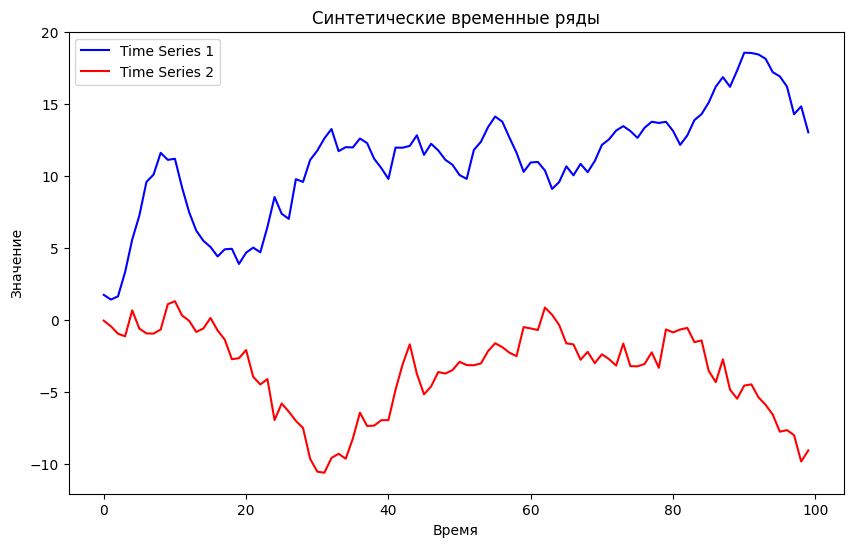

In [9]:
# Построение графиков
plt.figure(figsize=(10, 6))

# Построение первого временного ряда
plt.plot(ts1, label="Time Series 1", color='b')

# Построение второго временного ряда
plt.plot(ts2, label="Time Series 2", color='r')

# Добавление заголовка и меток осей
plt.title("Синтетические временные ряды")
plt.xlabel("Время")
plt.ylabel("Значение")

# Добавление легенды
plt.legend()

# Отображение графика
plt.show()

In [10]:
# Вычисление евклидова расстояния с использованием sktime и вашей функции
dist1 = euclidean_distance(ts1, ts2)
dist2 = ED_distance(ts1, ts2)

In [11]:
# Вывод результатов
print(f"Euclidean distance (sktime): {dist1}")
print(f"Euclidean distance (custom): {dist2}")

Euclidean distance (sktime): 156.27272956475048
Euclidean distance (custom): 156.27272956475048


In [12]:
def test_distances(dist1: float, dist2: float) -> None:
    """
    Проверка правильности реализации функции расстояния.

    Parameters
    ----------
    dist1 : Расстояние, вычисленное библиотекой sktime
    dist2 : Расстояние, вычисленное вашей функцией
    """
    try:
        np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Расстояния не равны')
        print("Тест пройден: расстояния равны.")
    except AssertionError as e:
        print(f"Ошибка: {e}")

In [13]:
# Тестирование
test_distances(dist1, dist2)

Тест пройден: расстояния равны.


### **Задача 2.**

Реализуйте самостоятельно функцию `DTW_distance()` в модуле *metrics.py*, которая вычисляет DTW расстояние между двумя временными рядами, имеющими одинаковую длину. Для вычисления расстояния между элементами временных рядов в DTW мере используйте евклидово расстояние. Временные ряды сгенерируйте аналогичным образом, как в задаче 1, или используйте уже созданные.

**Динамическая трансформация временной шкалы (Dynamic Time Warping, DTW)** – мера схожести между двумя временными рядами $T_1$ и $T_2$ длины $n$, вычисляемая следующим образом:

\begin{equation}
\text{DTW}(T_1, T_2) = d(n,n),
\\ d(i,j) = ({t_{1}}_i - {t_{2}}_j)^2 + \min \left\{
	\begin{array}{l l}
	d(i-1,j), \\
	d(i,j-1), \\
	d(i-1,j-1),
	\end{array}
	\right.
\\ d(0,0)=0, \quad d(i,0)=d(0,j)=\infty, \quad  1 \leqslant i,j \leqslant n.
\end{equation}

Сравните свои результаты с результатами функции [`dtw_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.dtw_distance.html) из библиотеки *sktime*. Для этого используйте `test_distances()` из задачи 1.

In [31]:
# INSERT YOUR CODE

In [35]:
# Генерация временных рядов
ts1 = random_walk(100)
ts2 = random_walk(100)


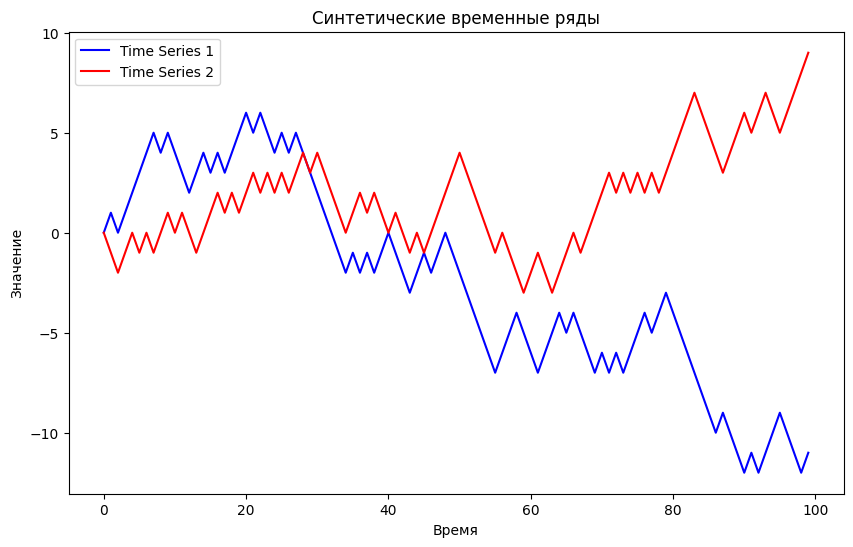

In [36]:
# Построение графиков
plt.figure(figsize=(10, 6))

# Построение первого временного ряда
plt.plot(ts1, label="Time Series 1", color='b')

# Построение второго временного ряда
plt.plot(ts2, label="Time Series 2", color='r')

# Добавление заголовка и меток осей
plt.title("Синтетические временные ряды")
plt.xlabel("Время")
plt.ylabel("Значение")

# Добавление легенды
plt.legend()

# Отображение графика
plt.show()

In [37]:
# Вычисление DTW расстояния между временными рядами
distance = DTW_distance(ts1, ts2)
print(f"DTW расстояние между временными рядами: {distance}")

DTW расстояние между временными рядами: 5358.0


In [38]:
# Вычисление расстояний
dist1 = dtw_distance(ts1, ts2)  # Библиотечная функция
dist2 = DTW_distance(ts1, ts2)  # Ваша функция


In [39]:
# Тестирование
test_distances(dist1, dist2)

# Вывод результатов
print(f"DTW distance (sktime): {dist1}")
print(f"DTW distance (custom): {dist2}")

Тест пройден: расстояния равны.
DTW distance (sktime): 5358.0
DTW distance (custom): 5358.0


### **Задача 3.**
Реализуйте нахождение матрицы расстояний между несколькими временными рядами.
Для этого заполните все методы c недостающим кодом в классе `PairwiseDistance` из модуля *pairwise_distance.py*. Для вычисления расстояний между рядами используйте ранее реализованные вами функции `ED_distance()` и `DTW_distance()` из модуля *metrics.py*.

Матрица расстояний между временными рядами определяется следующим образом. Пусть дано множество $S$, состоящее из $K$ временных рядов длины $n$: $\;S = \{T_1, T_2, ..., T_K\}, \; T_i \in \mathbb{R}^n$. Тогда под **матрицей расстояний** $D \in \mathbb{R}^{K \times K}$ понимается квадратная матрица, где каждый ее элемент $d(i,j)$ представляет собой расстояние между временными рядами $T_i$ и $T_j$ из множества $S$:
\begin{equation}
d(i,j) = dist(T_i, T_j), \quad T_i, T_j \in S, \quad 1 \leqslant i,j \leqslant K.
\end{equation}

Поскольку евклидова метрика и DTW мера удовлетворяют аксиоме симметричности (т.е. $dist(T_i, T_j)=dist(T_j, T_i)$), то матрица расстояний $D$ будет симметричной относительно главной диагонали. Для ускорения вычислений достаточно найти ее верхний треугольник, а нижний треугольник матрицы заполнить значениями верхнего треугольника следующим образом:
\begin{equation}
d(j,i) = d(i,j), \; где \; i < j.
\end{equation}

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/distance_matrix.png?raw=true" width="600"></center>

Сгенерируйте множество, состоящее из $K$ временных рядов некоторой длины $n$. Вычислите матрицы евклидовых и DTW расстояний между ними. Проверьте реализованные вами методы, сравнив свои результаты с результатами функции [`pairwise_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.pairwise_distance.html) из библиотеки *sktime*.

In [41]:
import numpy as np
from modules.metrics import ED_distance, DTW_distance

In [47]:
def random_walk(n):
    return np.cumsum(np.random.randn(n))

# Генерация множества временных рядов
ts1 = random_walk(100)
ts2 = random_walk(100)
ts3 = random_walk(100)
time_series = np.array([ts1, ts2, ts3])

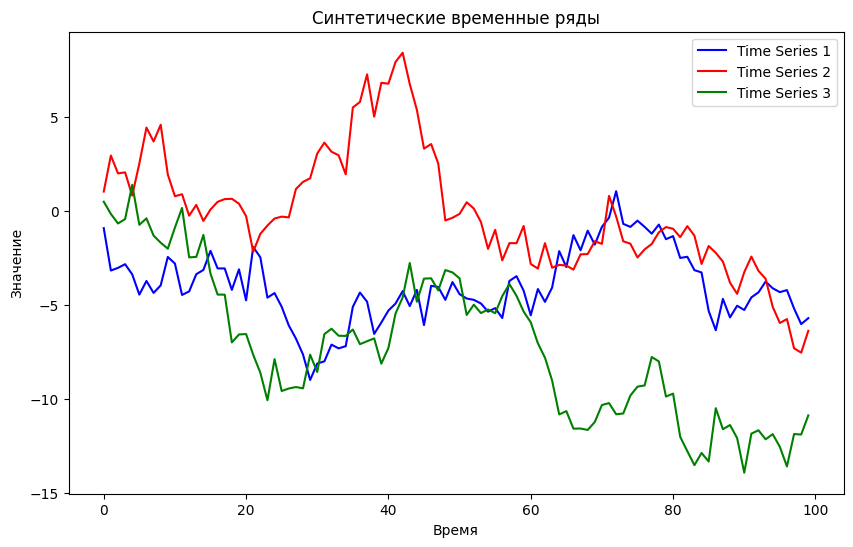

In [53]:
# Построение графиков
plt.figure(figsize=(10, 6))

# Построение первого временного ряда
plt.plot(ts1, label="Time Series 1", color='b')

# Построение второго временного ряда
plt.plot(ts2, label="Time Series 2", color='r')

# Построение второго временного ряда
plt.plot(ts3, label="Time Series 3", color='g')

# Добавление заголовка и меток осей
plt.title("Синтетические временные ряды")
plt.xlabel("Время")
plt.ylabel("Значение")

# Добавление легенды
plt.legend()

# Отображение графика
plt.show()

In [43]:
# Инициализация класса PairwiseDistance для евклидовых расстояний
pairwise = PairwiseDistance(metric='euclidean')

# Вычисление матрицы евклидовых расстояний вручную
euclidean_matrix = pairwise.calculate(time_series)
print("Euclidean Distance Matrix (Manual Calculation):\n", euclidean_matrix)

Euclidean Distance Matrix (Manual Calculation):
 [[  0.         128.07449018  77.60305942]
 [128.07449018   0.          76.48353027]
 [ 77.60305942  76.48353027   0.        ]]


In [44]:
from sktime.distances import pairwise_distance

# Вычисление расстояний с использованием sktime
sktime_matrix = pairwise_distance(time_series, metric="euclidean")
print("Euclidean Distance Matrix (sktime):\n", sktime_matrix)

Euclidean Distance Matrix (sktime):
 [[  0.         128.07449018  77.60305942]
 [128.07449018   0.          76.48353027]
 [ 77.60305942  76.48353027   0.        ]]


#### Тестирование матриц

In [45]:
def test_matrices(matrix1: np.ndarray, matrix2: np.ndarray) -> None:
    """
    Проверка правильности вычисления матрицы расстояний

    Parameters
    ----------
    matrix1 : Матрица расстояний, вычисленная библиотекой sktime
    matrix2 : Матрица расстояний, вычисленная вашей функцией
    """
    np.testing.assert_equal(matrix1.round(5), matrix2.round(5), 'Matrices are not equal')
    print("Тест пройден: матрицы равны.")

# Тестирование
test_matrices(euclidean_matrix, sktime_matrix)

Тест пройден: матрицы равны.


In [46]:
# Инициализация класса PairwiseDistance для DTW расстояний
pairwise_dtw = PairwiseDistance(metric='dtw')

# Вычисление матрицы DTW расстояний вручную
dtw_matrix = pairwise_dtw.calculate(time_series)
print("DTW Distance Matrix (Manual Calculation):\n", dtw_matrix)

# Вычисление расстояний с использованием sktime
sktime_dtw_matrix = pairwise_distance(time_series, metric="dtw")
print("DTW Distance Matrix (sktime):\n", sktime_dtw_matrix)

# Тестирование
test_matrices(dtw_matrix, sktime_dtw_matrix)

DTW Distance Matrix (Manual Calculation):
 [[    0.         13922.19756457  4307.87184563]
 [13922.19756457     0.          2368.39066908]
 [ 4307.87184563  2368.39066908     0.        ]]
DTW Distance Matrix (sktime):
 [[    0.         13922.19756457  4307.87184563]
 [13922.19756457     0.          2368.39066908]
 [ 4307.87184563  2368.39066908     0.        ]]
Тест пройден: матрицы равны.


### **Задача 4.**
Далее рассмотрим задачу иерархической кластеризации временных рядов, где будет использоваться предвычисленная матрица расстояний.

Для этого сначала загрузите набор временных рядов CBF из файла *CBF_TRAIN.txt*, который располагается в директории *./datasets/part1*. Каждая строка данного файла содержит целевую переменную (класс: 0, 1 или 2) в первом столбце и временной ряд в остальных столбцах. Набор CBF является синтетическим и включает в себя 30 временных рядов,  каждый из которых принадлежит к одному из трех классов.

#### 1. Загрузка данных

In [54]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

In [69]:
# Загрузка данных
file_path = r"C:\Users\Андрей гл\OBUCHENIE\3 СЕМЕСТР\репозиторий1\TimeSeriesCourse\practice\01 Basics\datasets\part1\CBF_TRAIN.txt"

# Чтение данных
data = pd.read_csv(file_path, sep='\s+', header=None)


In [70]:
# Отделение классов от временных рядов
classes = data.iloc[:, 0]  # Классы
time_series = data.iloc[:, 1:]  # Временные ряды
# Проверка результата
print(classes.head())
print(time_series.head())

0    1.0
1    1.0
2    1.0
3    3.0
4    2.0
Name: 0, dtype: float64
        1         2         3         4         5         6         7    \
0 -0.464276 -0.555048 -0.842843 -0.865895 -0.936396 -0.817270 -0.263612   
1 -0.896972 -0.685686 -1.351382 -1.458667 -1.165346 -1.403929 -1.821800   
2 -0.464696 -0.567739 -0.032023 -0.635046 -0.602826 -0.266856 -0.267061   
3 -0.187190 -0.620808 -0.815661 -0.521398 -0.790423 -0.967517 -1.487006   
4 -1.136017 -1.319195 -1.844624 -0.788692 -0.251715 -1.487603 -0.668764   

        8         9         10   ...       119       120       121       122  \
0 -1.258048 -1.250393 -0.918308  ... -1.331086 -1.083700 -1.017961 -0.916029   
1 -0.831601 -1.016312 -0.803530  ... -1.062553 -1.568676 -1.364040 -1.155177   
2 -0.931042 -0.449382 -0.721342  ... -0.286721 -0.637158 -0.155260 -0.688129   
3 -0.277887 -0.835075  0.050591  ... -0.908615 -0.726286  0.183778 -0.737444   
4 -0.340360 -1.046382 -0.312214  ... -1.182911 -1.073514 -1.611362 -1.064340   


In [71]:
# Преобразование классов в целые и строковые значения
labels = classes.astype(int).astype(str).tolist()


In [72]:
# Убедимся, что количество меток соответствует количеству временных рядов
print(f"Количество классов: {len(labels)}, Количество временных рядов: {len(time_series)}")



Количество классов: 30, Количество временных рядов: 30


In [73]:
# Проверим уникальные значения меток, чтобы убедиться, что они корректны
print(f"Уникальные классы: {set(labels)}")


Уникальные классы: {'3', '1', '2'}


In [74]:
# Вычисление сжатой матрицы расстояний (например, Евклидово расстояние)
distance_matrix = pdist(time_series, metric='euclidean')

In [75]:
# Иерархическая кластеризация (передаем сжатую матрицу)
Z = linkage(distance_matrix, method='ward')

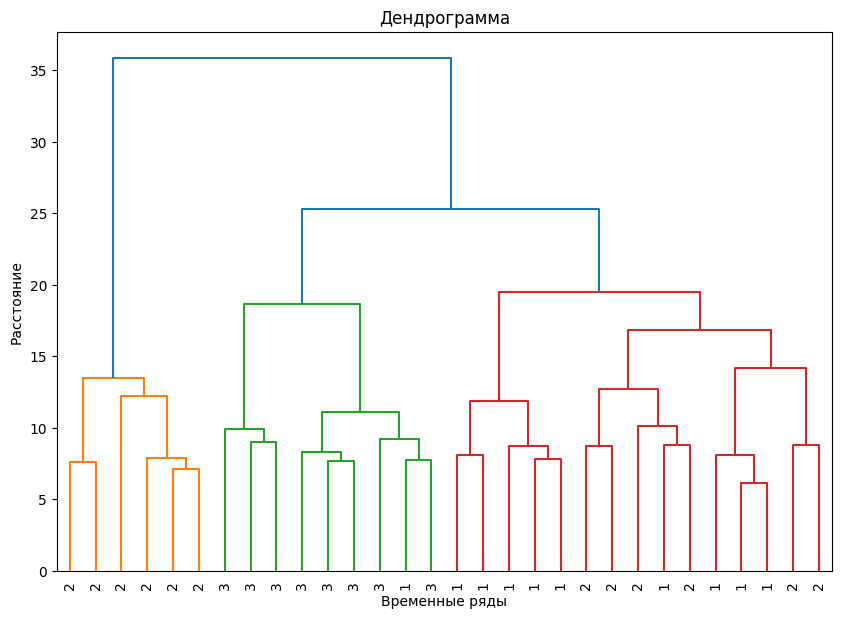

In [76]:
# Визуализация дендрограммы
plt.figure(figsize=(10, 7))

# Используем список меток для дендрограммы с настройкой вращения и размера шрифта
dendrogram(Z, labels=labels, leaf_rotation=90, leaf_font_size=10)

plt.title('Дендрограмма')
plt.xlabel('Временные ряды')
plt.ylabel('Расстояние')
plt.show()

Далее самостоятельно реализуйте класс `TimeSeriesHierarchicalClustering` из модуля *clustering.py*, который выполняет иерархическую кластеризацию временных рядов.

Перед тем как приступить к реализации, изучите скелет этого класса. Реализуйте метод `fit()`, выполняющий кластеризацию данных на основе предвычисленной матрицы расстояний, которая передается в данный метод. Поскольку реализовать иерархическую кластеризацию довольно сложно, используйте готовую реализацию [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) из *sklearn*.   

Выполните иерархическую кластеризацию загруженных временных рядов CBF для двух функций расстояния: евлидовой метрики и DTW меры.
Для этого сначала найдите матрицы расстояний между временными рядами, используя класс `PairwiseDistance`, и передайте каждую матрицу в метод `fit()` для кластеризации.
Далее выполните визуализацию результатов в виде дендрограмм с помощью метода `plot_dendrogram()`, передав исходный набор временных рядов и их метки.

In [384]:
import sys
import os
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dtaidistance import dtw

In [385]:
# Указываем путь к папке, где находится clustering.py
module_path = r"C:\Users\Андрей гл\OBUCHENIE\3 СЕМЕСТР\репозиторий1"
# Добавляем этот путь в sys.path
if module_path not in sys.path:
    sys.path.append(module_path)

In [386]:
# Импортируем класс для иерархической кластеризации
from clustering1 import TimeSeriesHierarchicalClustering


In [387]:
# Загрузим временные ряды (замените на ваши данные)
data = np.loadtxt(r"C:\Users\Андрей гл\OBUCHENIE\3 СЕМЕСТР\репозиторий1\TimeSeriesCourse\practice\01 Basics\datasets\part1\CBF_TRAIN.txt")
classes = data[:, 0]  # Классы
time_series = data[:, 1:]  # Временные ряды


In [388]:
# --- Кластеризация с использованием Евклидовой метрики ---

# Используем временные ряды напрямую для метода 'ward'
clustering_euclidean = TimeSeriesHierarchicalClustering(n_clusters=3, method='ward')


In [389]:
# Кластеризация с использованием евклидовой метрики, передавая исходные данные
labels_euclidean = clustering_euclidean.fit(time_series)


In [390]:
# Получаем метки кластеров после кластеризации
labels_euclidean = clustering_euclidean.model.labels_
print("Метки кластеров для евклидовой метрики:", labels_euclidean)


Метки кластеров для евклидовой метрики: [0 0 2 2 1 0 0 2 0 0 0 0 0 0 1 2 1 1 0 2 1 1 0 0 2 2 0 2 2 0]


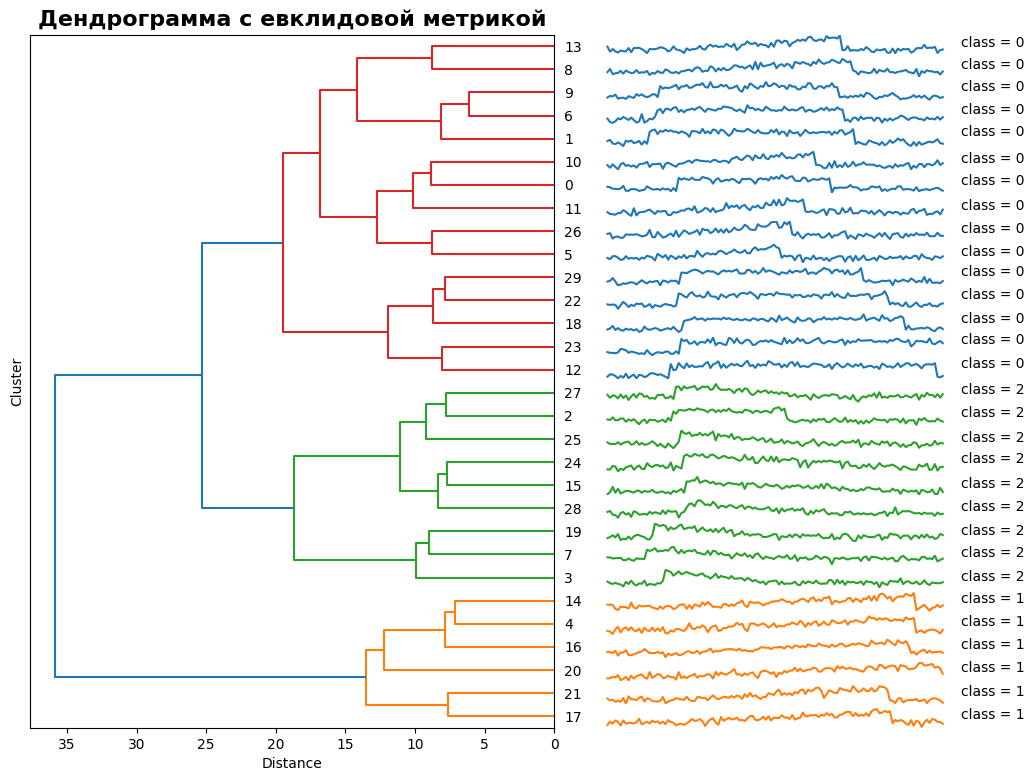

In [391]:
# Визуализация дендрограммы для евклидовой метрики
clustering_euclidean.plot_dendrogram(time_series, labels_euclidean, title='Дендрограмма с евклидовой метрикой')


In [392]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from dtaidistance import dtw

# --- Кластеризация с использованием DTW ---
clustering_dtw = AgglomerativeClustering(n_clusters=3, metric='precomputed', linkage='average')

# Рассчитываем матрицу DTW расстояний
distance_matrix_dtw = np.zeros((len(time_series), len(time_series)))

for i in range(len(time_series)):
    for j in range(i+1, len(time_series)):
        distance_matrix_dtw[i, j] = dtw.distance(time_series[i], time_series[j])
        distance_matrix_dtw[j, i] = distance_matrix_dtw[i, j]

# Выполняем кластеризацию с использованием матрицы DTW расстояний
labels_dtw = clustering_dtw.fit_predict(distance_matrix_dtw)

print("Метки кластеров для DTW метрики:", labels_dtw)

Метки кластеров для DTW метрики: [0 0 0 2 0 0 0 2 0 0 0 0 1 0 0 2 0 0 0 2 0 0 0 1 2 2 0 2 2 0]


In [395]:
import sys
import os
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dtaidistance import dtw

E:\ANACONDA 28.05.24\envs\tf1\lib\site-packages\sklearn\cluster\_agglomerative.py:586: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



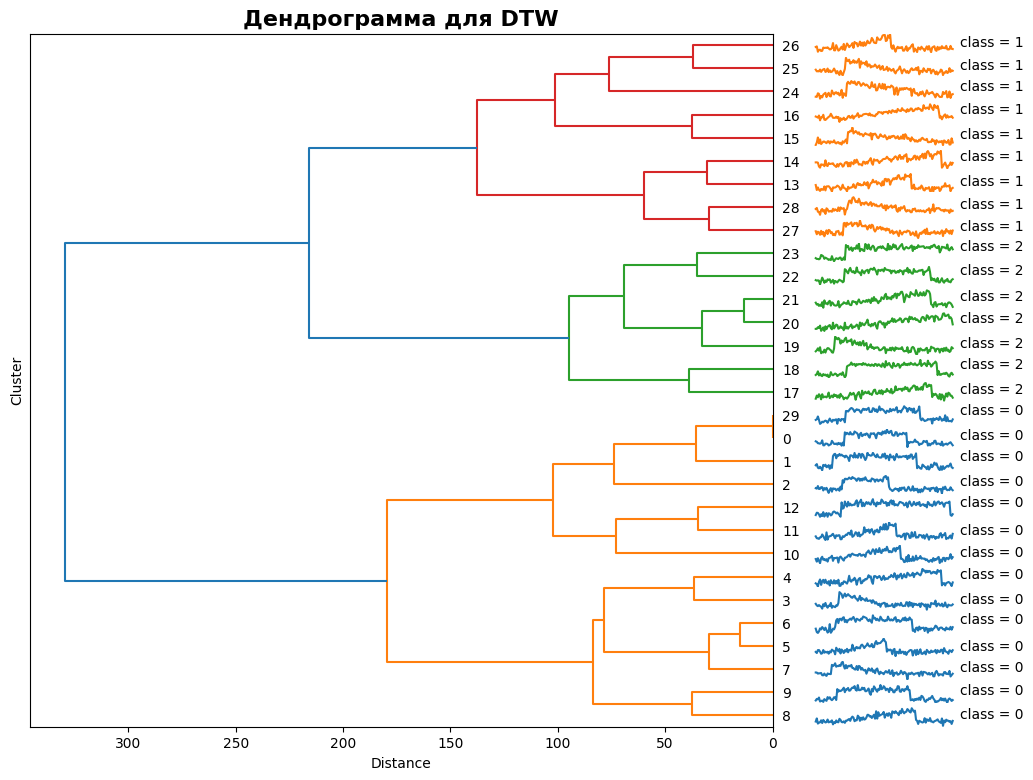

In [449]:

# --- Кластеризация с использованием DTW метрики ---
# 1. Вычисляем матрицу расстояний для DTW
dtw_pairwise_distance_calculator = PairwiseDistance(metric='dtw')
dtw_distance_matrix = dtw_pairwise_distance_calculator.calculate(ts_set)

# 2. Выполняем кластеризацию
hierarchical_clustering_dtw = TimeSeriesHierarchicalClustering(n_clusters=3, method='complete')
dtw_labels = hierarchical_clustering_dtw.fit_predict(dtw_distance_matrix)

# 3. Визуализируем результаты в виде дендрограммы
hierarchical_clustering_dtw.plot_dendrogram(time_series, dtw_labels, ts_hspace=5, title='Дендрограмма для DTW')

In [450]:
from tslearn.metrics import dtw
from scipy.spatial.distance import pdist, squareform

def compute_distance_matrix(ts_set, metric='euclidean'):
    if metric == 'euclidean':
        # Вычисление матрицы расстояний с использованием евклидовой метрики
        distance_matrix = squareform(pdist(ts_set, metric='euclidean'))
    elif metric == 'dtw':
        # Вычисление матрицы расстояний с использованием DTW меры
        n = len(ts_set)
        distance_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                distance = dtw(ts_set[i], ts_set[j])
                distance_matrix[i, j] = distance
                distance_matrix[j, i] = distance  # Матрица симметрична
    else:
        raise ValueError("Unsupported metric")
    return distance_matrix

# Вычисление матриц расстояний
distance_matrix_euclidean = compute_distance_matrix(ts_set, metric='euclidean')
distance_matrix_dtw = compute_distance_matrix(time_series, metric='dtw')

In [451]:
distance_matrix_dtw

array([[0.        , 3.27320769, 3.60211586, 5.64873574, 5.15977517,
        6.42202955, 3.20808855, 5.33825657, 5.05254338, 2.89549336,
        5.37463459, 6.24507326, 7.79088138, 5.33439591, 5.11615316,
        4.81633087, 4.44830235, 5.13819605, 3.63988296, 5.42284693,
        5.8989389 , 4.63084592, 3.51631212, 7.05966022, 4.4167129 ,
        5.69952026, 5.79686301, 5.15265885, 5.24459285, 3.05741483],
       [3.27320769, 0.        , 4.63445451, 6.6416903 , 4.9636862 ,
        6.95591652, 2.98218232, 6.0507074 , 5.33059264, 2.94023243,
        5.76901984, 7.02480509, 5.45369121, 5.74578498, 5.18647428,
        5.53270125, 5.20018002, 5.24454365, 2.72574324, 6.56901219,
        6.85453695, 5.23438459, 2.84925055, 6.8703424 , 4.74801319,
        6.33378164, 6.67745409, 6.07439849, 6.11662717, 2.73468582],
       [3.60211586, 4.63445451, 0.        , 4.81196302, 5.49860555,
        4.5725616 , 4.51503733, 4.84266311, 4.06126538, 4.03631475,
        3.98593717, 4.94855812, 8.55561648, 4.

In [452]:
def cluster_and_evaluate_euclidean(ts_set, n_clusters):
    # Вычисление матрицы расстояний евклидовой метрики
    distance_matrix_euclidean = compute_distance_matrix(ts_set, metric='euclidean')
    
    # Кластеризация
    clustering = AgglomerativeClustering(n_clusters=n_clusters,linkage='average')
    labels = clustering.fit_predict(distance_matrix_euclidean)

    # Вычисление силуэтного коэффициента
    silhouette_avg = silhouette_score(distance_matrix_euclidean, labels, metric='precomputed')
    
    return labels, silhouette_avg

In [453]:
n_clusters = 3  # Задайте желаемое количество кластеров
labels_euclidean, silhouette_avg_euclidean = cluster_and_evaluate_euclidean(ts_set, n_clusters)

print(f"Метки кластеров (евклидово расстояние): {labels_euclidean}")
print(f"Силуэтный коэффициент (евклидово расстояние): {silhouette_avg_euclidean}")

Метки кластеров (евклидово расстояние): [1 1 1 1 1 1 1 1 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
Силуэтный коэффициент (евклидово расстояние): 0.3710865700698936


E:\ANACONDA 28.05.24\envs\tf1\lib\site-packages\sklearn\cluster\_agglomerative.py:586: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [454]:
def cluster_and_evaluate(ts_set, n_clusters):
    # Вычисление матрицы расстояний DTW
    distance_matrix_dtw = compute_distance_matrix(ts_set, metric='dtw')
    
    # Преобразование матрицы в векторный формат для linkage
    distance_vector = squareform(distance_matrix_dtw)
    
    # Кластеризация
    Z = linkage(distance_vector, method='average')
    labels = fcluster(Z, t=n_clusters, criterion='maxclust')
    
    # Вычисление силуэтного коэффициента
    silhouette_avg = silhouette_score(distance_matrix_dtw, labels, metric='precomputed')
    
    return labels, silhouette_avg

In [455]:
# Пример: предположим, что ts_set - это ваш набор временных рядов
n_clusters = 3  # Задайте желаемое количество кластеров
labels, silhouette_avg = cluster_and_evaluate(ts_set, n_clusters)

print(f"Метки кластеров: {labels}")
print(f"Силуэтный коэффициент: {silhouette_avg}")

Метки кластеров: [3 3 3 3 3 3 3 3 3 3 3 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3]
Силуэтный коэффициент: 0.4991091003007462


Сравните результаты иерархической кластеризации, полученные при двух различных функций расстояния, с помощью силуэтного коэффициента. Для этого используйте функцию [`silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) из библиотеки *sklearn*, передав в нее предвычисленную матрицу расстояний и предсказанные метки.

**Силуэтный коэффициент** – метрика, которая оценивает качество кластеризации на основе исходной выборки и результатов кластеризации без необходимости знания об истинных метках объектов.

Силуэтный коэффициент для выборки показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Пусть дана выборка $X$, состоящая из $N$ объектов. Предположим, что объекты этой выборки были разбиты на кластеры $c_1, ... c_K$, $c_i \in C$, с помощью некоторого алгоритма кластеризации. Тогда силуэтный коэффициент для выборки будет вычисляться следующим образом:

\begin{equation}
sil\_coef = \frac{1}{N} \sum_{c_k \in C} \sum_{x_i \in c_k} \frac{b(x_i, c_k) - a(x_i, c_k)}{\max(a(x_i, c_k), b(x_i, c_k))},
\end{equation}

где $a(x_i, c_k)$ – среднее расстояние от объекта $x_i \in c_k$ до других объектов из этого же кластера $c_k$; <br> $b(x_i, c_k)$  – среднее расстояние от объекта $x_i \in c_k$ до объектов из другого кластера $c_l$, $k \neq l$.

Силуэтный коэффициент принимает значения от  −1  до  1:
*   –1 означает, что кластеры плохие, размытые;
*   0 означает, что кластеры накладываются друг на друга;
*   1 означает, что кластеры плотные и хорошо отделены друг от друга.

Таким образом, чем ближе значение коэффициента к 1, тем лучше кластеризованы данные.

In [ ]:
# INSERT YOUR CODE

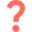
Проанализируйте полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Какая, на ваш взгляд, функция расстояния показала лучший результат и почему? Укажите, в каких случаях более предпочтительно использовать DTW меру, чем евклидову метрику.

*# WRITE YOUR ANSWER*

## **Часть 2.** $Z$-нормализация временных рядов.

### **Задача 5.**
Реализуйте функцию вычисления нормализованного евклидова расстояния между временными рядами `norm_ED_distance()` в модуле *metrics.py* и проверьте правильность своей реализации, сравнив полученные результаты с результатами функции [`ed_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, в которую необходимо передать <u>нормализованные</u> временные ряды. Для нормализации временных рядов используйте функцию `z-normalize()` из *utils.py*.  Для проверки можно использовать синтетические временные ряды из первой части или заново их сгенерировать.

**Нормализованная евклидова метрика** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
	\text{ED}_{norm}(T_1, T_2) = \sqrt {\Big|\; 2n\left(1-\dfrac{<T_1, T_2> - \; n \; \cdotp \mu_{T_1} \; \cdotp \mu_{T_2}}{n \; \cdotp \sigma_{T_1} \; \cdotp \sigma_{T_2}}\right)\Big|},
\end{equation}

где $<T_1, T_2>$ – скалярное произведение временных рядов, $\mu_{T_1}$ и $\mu_{T_2}$, $\sigma_{T_1}$ и $\sigma_{T_2}$ – среднее арифметическое и стандартное отклонение временных рядов соответственно.

**Среднее арифметическое** $\mu_T$ и **стандартное отклонение** $\sigma_T$ временного ряда $T$ длины $n$ вычисляются по следующим формулам:

\begin{equation}
	\mu_{T} = \frac{1}{n}\sum\limits_{i=1}^{n} t_{i}, \\[1em]
	\sigma_{T} = \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n} t_i^2-\mu_{T}^2}.
\end{equation}

In [ ]:
# INSERT YOUR CODE

#### 1. Создание синтетических временных рядов

In [1]:
import numpy as np

# Создаем два случайных временных ряда длиной 100
ts1 = np.random.randn(100)
ts2 = np.random.randn(100)

#### 2. Применение функции z-normalize() к временным рядам

In [2]:
import utils
import inspect

# Узнаем путь к файлу модуля
print(inspect.getfile(utils))

C:\Users\Андрей гл\OBUCHENIE\3 СЕМЕСТР\репозиторий1\utils.py


In [3]:
from utils import z_normalize

# Нормализуем временные ряды
norm_ts1 = z_normalize(ts1)
norm_ts2 = z_normalize(ts2)

#### 3. Вычисление нормализованного евклидова расстояния

In [4]:
from metrics import norm_ED_distance

# Вычисляем нормализованное евклидово расстояние
distance = norm_ED_distance(norm_ts1, norm_ts2)
print(f"Нормализованное евклидово расстояние: {distance}")

Нормализованное евклидово расстояние: 14.005083558679898


#### 4. Сравнение с результатами функции ed_distance() из sktime

In [6]:
from sktime.distances import pairwise_distance

# Вычисляем евклидово расстояние между двумя временными рядами
sklearn_distance = pairwise_distance(norm_ts1.reshape(1, -1), norm_ts2.reshape(1, -1), metric="euclidean")
print(f"Евклидово расстояние: {sklearn_distance}")

Евклидово расстояние: [[14.00508356]]


### **Задача 6.**
Далее убедимся, что выполнение $z$-нормализации на этапе предобработки данных имеет важное значение и может повысить точность решаемой задачи.

В данном задании вы продолжите решать задачу иерархической кластеризации. В качестве данных будут использоваться два временных ряда из набора данных [BIDMC](https://physionet.org/content/chfdb/1.0.0/). Набор BIDMC состоит из записей ЭКГ-сигналов, снятых с 15 пациентов с сердечной недостаточностью тяжелой степени.  

Загрузите два временных ряда и визуализируйте их с помощью функции `plot_ts()` из модуля *plots.py*.

In [4]:
url1 = './datasets/part2/chf10.csv'
ts1 = read_ts(url1)

url2 = './datasets/part2/chf11.csv'
ts2 = read_ts(url2)

NameError: name 'read_ts' is not defined

In [5]:
ts_set = np.concatenate((ts1, ts2), axis=1).T

NameError: name 'ts1' is not defined

In [6]:
plot_ts(ts_set)

In [54]:
import numpy as np

In [55]:
from sklearn.cluster import AgglomerativeClustering

In [57]:
from sklearn.metrics import silhouette_score

In [58]:
from pairwise_distance import PairwiseDistance

In [59]:
from plots import plot_dendrogram

ImportError: cannot import name 'plot_dendrogram' from 'plots' (C:\Users\Андрей гл\OBUCHENIE\3 СЕМЕСТР\репозиторий1\plots.py)

In [53]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from pairwise_distance import PairwiseDistance
from plots import plot_dendrogram

ImportError: cannot import name 'plot_dendrogram' from 'plots' (C:\Users\Андрей гл\OBUCHENIE\3 СЕМЕСТР\репозиторий1\plots.py)

Разделите каждый временной ряд на непересекающиеся подпоследовательности с помощью техники скользящего окна. Для этого используйте функцию `sliding_window()` из модуля *utils.py*, передав в нее временной ряд, заданную длину подпоследовательности и величину шага. В нашем случае, величина шага равна длине подпоследовательности.

In [ ]:
m = 125
subs_set1 = sliding_window(ts_set[0], m, m-1)
subs_set2 = sliding_window(ts_set[1], m, m-1)

Сформируйте множество всех подпоследовательностей, извлеченных из двух временных рядов, и массив меток подпоследовательностей в соответствии с их принадлежностью к временному ряду.

In [ ]:
subs_set = np.concatenate((subs_set1[0:15], subs_set2[0:15]))
labels = np.array([0]*subs_set1[0:15].shape[0] + [1]*subs_set2[0:15].shape[0])

Добавьте в класс `PairwiseDistance` из модуля *pairwise_distance.py* возможность вычисления нормализованной евклидовой метрики между временными рядами. Если матрица расстояний строится для нормализованных временных рядов на основе евклидовой метрики, то должна вызываться функция `norm_ED_distance()`. Для остальных метрик/мер схожести перед нахождением матрицы расстояний временные ряды должны подтвергаться $z$-нормализации с помощью функции `z_normalize()` из модуля *utils.py*.

Далее выполните иерархическую кластеризацию подпоследовательностей двух временных рядов с использованием предварительно построенных матриц расстояний на основе классической и нормализованной евклидовой метрики.

In [ ]:
# INSERT YOUR CODE

Вычислите силуэтные коэффициенты для оценки качества кластеризации с нормализацией и без нее, как это было сделано в задаче 4 части 1.

In [ ]:
# INSERT YOUR CODE

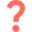
Сравните полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Позволила ли $z$-нормализации временных рядов повысить качество кластеризации?

*# WRITE YOUR ANSWER*

## **Часть 3.** Классификация изображений, представленных в виде временных рядов.

### **Задача 7.**
В данном задании вам предстоит выполнить преобразование изображения, на котором находится некоторый объект, во временной ряд. Для этого вы реализуете один из существующих методов, предложенный в [статье Кеога и др](https://dl.acm.org/doi/10.5555/1182635.1164203).

Данный метод заключается в том, что сначала на изображении выполняется поиск контура $E = \{e_i\}_{i=1}^L$, где $e_i$ – точки контура, и центра масс объекта $O$. Затем берутся точки, расположенные на контуре объекта, следующим образом.

Рассмотрим луч $OP$ с началом в центре масс объекта $O$, направление которого совпадает с положительным направлением оси Ox (см. рисунок). Далее выполняется поворот против часовой стрелки луча $OP$ вокруг центра масс $O$ на некоторый заданный угол $α$, $1° \leqslant α \leqslant 360°$. Поворот луча будет осуществляться до тех пор, пока луч не пройдет полный оборот. Все точки $P = \{P_i\}_{i=1}^K$, $P_i \in E$, $K = \lfloor \frac{360°}{α} \rfloor$, образованные пересечением луча $OP$ с контуром $E$ во время поворота, будут являться искомыми.

На завершающем шаге метода вычисляются расстояния между центром масс объекта $O$ и найденными точками на контуре $P$. В качестве функции расстояния может быть использовано манхэттенское или евклидово расстояние. Полученные расстояния будут формировать временной ряд $T$ длины $K$:
\begin{equation}
T = \{t_i\}_{i=1}^K,\;где \; t_i = dist(O, P_i), \; P_i \in P.
\end{equation}

\
<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/image2ts.png?raw=true" width="1000"></center>

Поскольку часть 3 предполагает работу с изображениями, то вы будете использовать для реализации некоторых частей кода библиотеку компьютерного зрения *cv2*. Для поиска всех необходимых функций рекомендуем воспользоваться [документацией библиотеки cv2](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html).

Загрузите изображение *example.tif* из директории *./datasets/part3* и выполните его визуализацию с помощью соответствующих функций из библиотеки *cv2*.

In [ ]:
# INSERT YOUR CODE

За конвертацию изображения во временной ряд с помощью описанного выше метода отвечает функция `image2ts()` из модуля *image_converter.py*. Прежде чем исходное изображение будет преобразовано во временной ряд, сначала оно должно пройти этап предварительной обработки. Предварительная обработка включает в себя следующие шаги:

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/image_preprocessing.png?raw=true" width="1000"></center>

Предобработка изображения в `image2ts()` осуществляется с помощью функции `_img_preprocess()`. Реализуйте в данной функции все представленные на диаграмме шаги предварительной обработки средствами библиотеки *cv2*. Промежуточные результаты должны совпадать с представленными на диаграмме.

Далее выполните конвертацию изображения во временной ряд, передав в функцию `image2ts()` следующие заданные вами аргументы:
*   исходное загруженное изображение;
*   шаг угла поворота;
*   параметр, определяющий нужно или нет визуализировать изображение с выделенными на нем контуром, центром масс и лучами, проведенными из центра.

Визуализируйте полученный временной ряд.


In [ ]:
angle_step = 20
visualize = True

ts = image2ts(img, angle_step, visualize)
plot_ts(np.array([ts]), "Time series representation of image")

### **Задача 8.**

Выполните классификацию изображений, представленных в виде временных рядов, с помощью метода $k$ ближайших соседей (kNN).

**Метод $k$ ближайших соседей (kNN)** – алгоритм классификации, заключающийся в вычислении сходства между объектами на основе некоторой заданной метрики/меры схожести. Классифицируемый объект относится к тому классу, к которому принадлежит большинство из его $k$ соседей ($k$ ближайших к нему объектов из обучающей выборки).

Для классификации на основе алгоритма kNN необходимо выполнить следующие шаги:

1. Загрузить обучающую и тестовую выборки.

2. Задать параметр алгоритма $k$, где $k$ – количество ближайших соседей, $k \in \mathbb N^*$.

3. Для каждого объекта из тестовой выборки выполнить следующее:

    3.1. Вычислить расстояние до всех объектов из обучающей выборки на основе заданной метрики/меры схожести.
    
    3.2. Отсортировать в порядке возрастания найденные расстояния.

    3.3. Найти $k$ ближайших соседей, взяв первые $k$ минимальные расстояния из отсортированного массива расстояний.

    3.4. Назначить объекту из тестовой выборки наиболее часто встречающийся класс найденных ранее ближайших соседей.


Для этого задания вам предлагается набор данных, который содержит изображения листьев четырех различных пород деревьев: дуб, ольха, ива и липа. Набор данных состоит из обучающей и тестовой выборок, включающих по 15 и 10 изображений листьев на класс соответственно. Для составления этого набора данных изображения были взяты из [Swedish Leaf Dataset](https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/).

Загрузите изображения из обучающей и тестовой выборок, а также их метки, используя `read_images()` и `read_ts()` соответственно.
Выполните визуализацию прецедентов выборки с помощью функции `plot_images()`.


In [ ]:
def read_images(dir: str) -> list[np.ndarray]:
    """
    Load all images from a directory

    Parameters
    ----------
    dir: directory path

    Returns
    -------
    images: images from a directory
    """

    images = []
    for img_path in sorted(glob.glob(dir)):
        cv_img = cv2.imread(img_path)
        images.append(cv_img)

    return images

In [ ]:
def plot_images(images: list[np.ndarray], labels: np.ndarray, class_names: list[str]) -> None:
    """
    Plot some images from dataset

    Parameters
    ----------
    images: dataset of images
    labels: labels of images
    class_names: class names of images
    """

    rows = 2
    columns = 4

    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*2, rows*3))

    for num in range(1, rows*columns+1):
        fig.add_subplot(rows, columns, num)
        idx = num - 1
        plt.imshow(images[idx], aspect='auto')
        plt.title(f'{class_names[labels[idx]]}', fontsize=10)

    fig.tight_layout()

    for idx, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
train_set_path = "./datasets/part3/train_set_leaves/*.tif"
test_set_path = "./datasets/part3/test_set_leaves/*.tif"

train_images = read_images(train_set_path)
test_images = read_images(test_set_path)

train_label_path = './datasets/part3/train_set_leaves/train_label.csv'
test_label_path = './datasets/part3/test_set_leaves/test_label.csv'

train_labels = read_ts(train_label_path)
train_labels = train_labels.reshape(-1).astype('int32')

test_labels = read_ts(test_label_path)
test_labels = test_labels.reshape(-1).astype('int32')

In [ ]:
class_names = ['Quercus (дуб)', 'Alnus (ольха)', 'Salix (ива)', 'Tilia (липа)']
plot_images(train_images, train_labels, class_names)

Выполните преобразование изображений обучающей и тестовой выборок во временные ряды с помощью функции `image2ts()`.  

In [ ]:
# INSERT YOUR CODE

Для классификации временных рядов методом $k$ ближайших соседей вам необходимо использовать класс `TimeSeriesKNN` из модуля *classification.py*.
Реализуйте метод `fit()` в классе `TimeSeriesKNN`, который выполняет поиск для каждого элемента из тестовой выборки $k$ ближайших соседей и назначает им тот класс, который является часто встречающимся среди классов ближайших соседей. В качестве параметров в метод `fit()` передается тестовая выборка. Вычислите точность классификации по метрике accuracy с помощью функции `calculate_accurary()` из модуля *classification.py*.

In [ ]:
n_neighbors = 6
metric = 'euclidean'
metric_params = {'normalize': True}

# INSERT YOUR CODE

In [ ]:
metric = 'dtw'
metric_params = {'normalize': True}

# INSERT YOUR CODE

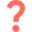
Проанализируйте результаты и сделайте выводы.

*# WRITE YOUR ANSWER*